In [ ]:
import pandas as pd
from sklearn.linear_model import LassoCV, Lasso, LogisticRegressionCV, LogisticRegression
import numpy as np
from sklearn.linear_model import LassoCV, LogisticRegressionCV
import doubleml as dml
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy.linalg import toeplitz
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
def parse_dml_output(dml_obj):
    output = str(dml_obj)
    # coef
    #coef_match = re.search(r"d\s+([-\d\.]+)\s+[.\d]+\s+[.\d]+\s+[.\d]+\s+[.\d]+\s+[.\d]+", output)
    coef = dml_obj.summary['coef'].values[0]   
    low_bound = dml_obj.summary["2.5 %"].values[0]
    high_bound = dml_obj.summary["97.5 %"].values[0]
    
    # RMSE'ler
    rmse_d0_match = re.search(r"Learner ml_g_d0 RMSE:\s+\[\[([\d\.]+)\]\]", output)
    rmse_d1_match = re.search(r"Learner ml_g_d1 RMSE:\s+\[\[([\d\.]+)\]\]", output)
    rmse_g_d0 = float(rmse_d0_match.group(1)) if rmse_d0_match else None
    rmse_g_d1 = float(rmse_d1_match.group(1)) if rmse_d1_match else None

    # Log loss'lar
    logloss_pi_match = re.search(r"Learner ml_pi Log Loss:\s+\[\[([\d\.]+)\]\]", output)
    logloss_m_match = re.search(r"Learner ml_m Log Loss:\s+\[\[([\d\.]+)\]\]", output)
    logloss_pi = float(logloss_pi_match.group(1)) if logloss_pi_match else None
    logloss_m = float(logloss_m_match.group(1)) if logloss_m_match else None

    return {
        "coef": coef,
        "2.5%": low_bound,
        "97.5%": high_bound,
        "rmse_g_d0": rmse_g_d0,
        "rmse_g_d1": rmse_g_d1,
        "logloss_pi": logloss_pi,
        "logloss_m": logloss_m,
    }

In [3]:
def make_ssm_data_custom(n_obs, theta, dim_x):
    sigma = np.array([[1, 0.8], [0.8, 1]])
    gamma = 1

    e = np.random.multivariate_normal(mean=[0, 0], cov=sigma, size=n_obs).T

    cov_mat = toeplitz([np.power(0.5, k) for k in range(dim_x)])
    x = np.random.multivariate_normal(np.zeros(dim_x), cov_mat, size=[n_obs, ])

    beta = [0.4 / (k**2) for k in range(1, dim_x + 1)]

    d = np.where(np.dot(x, beta) + np.random.randn(n_obs) > 0, 1, 0)
    z = np.random.randn(n_obs)
    s = np.where(np.dot(x, beta) + d + gamma * z + e[0] > 0, 1, 0)

    y = np.dot(x, beta) + theta * d + e[1]

    y[s == 0] = 0
    x_cols = [f'X{i + 1}' for i in np.arange(dim_x)]

    pi_oracle = norm.cdf(np.dot(x, beta) + d + gamma * z)

    return pd.DataFrame(np.column_stack((x, y, d, z, s)), columns= x_cols + ['y', 'd', 'z', 's']), pi_oracle

In [ ]:
def simulate(n_sim=100):
    results_tune_sep = []
    results_tune_nosep = []

    for seed in tqdm(range(n_sim)):
        np.random.seed(seed)
        df, pi_oracle = make_ssm_data_custom(n_obs=3000, theta=1, dim_x=100)
        y, d, s, z = df["y"], df["d"], df["s"], df["z"]
        X = df.drop(columns=["y", "d", "s", "z"])
        dml_data = dml.DoubleMLData(df, 'y', 'd', z_cols='z', s_col='s')
        pi_oracle = pd.Series(pi_oracle, name='pi_oracle', index=X.index)

        # SPLIT SAMPLE FOR FULL TUNE SEPARATED
        
        # split data to 2 with indices
        train0_indices, train1_indices = train_test_split(df.index, test_size=0.5, random_state=seed)
        X0, X1 = X.iloc[train0_indices], X.iloc[train1_indices]
        y0, y1 = y.iloc[train0_indices], y.iloc[train1_indices]
        d0, d1 = d.iloc[train0_indices], d.iloc[train1_indices]
        s0, s1 = s.iloc[train0_indices], s.iloc[train1_indices]
        z0, z1 = z.iloc[train0_indices], z.iloc[train1_indices]

        #### for ml_pi and sample0

        ml_pi_cv = LogisticRegressionCV(cv=5, max_iter=1000, scoring='neg_log_loss', penalty='l1', solver='liblinear')
        X_d_z0 = pd.concat([X0, d0, z0], axis=1)
        X_d_z1 = pd.concat([X1, d1, z1], axis=1)
        ml_pi_cv.fit(X_d_z0, s0)
        best_c_pi = ml_pi_cv.C_[0]

        # predicting other part of the data's pi_hat 
        pi_hat1 = ml_pi_cv.predict_proba(X_d_z1)[:, 1]
        pi_hat1 = pd.Series(pi_hat1, name='pi_hat', index=X1.index)

        # preparing tuned ml_pi
        ml_pi_tuned = LogisticRegression(C=best_c_pi, max_iter=1000, penalty='l1', solver='liblinear')

        #### for ml_m & ml_g and sample1

        # ml_m
        X_pi_hat1 = pd.concat([X1, pi_hat1], axis=1)
        ml_m_cv = LogisticRegressionCV(cv=5, max_iter=1000, scoring='neg_log_loss', penalty='l1', solver='liblinear')
        ml_m_cv.fit(X_pi_hat1, d1)
        best_c_m = ml_m_cv.C_[0]
        ml_m_tuned = LogisticRegression(C=best_c_m, max_iter=1000, penalty='l1', solver='liblinear')

        # ml_g_d0
        X_pi_hat_d1 = pd.concat([X1, d1, pi_hat1], axis=1)
        ml_g_d0_cv = LassoCV(cv=5, n_jobs=-1)
        mask_g_d0 = (s1 == 1) & (d1 == 0)
        ml_g_d0_cv.fit(X_pi_hat_d1[mask_g_d0], y1[mask_g_d0])
        ml_g_d0_tuned = Lasso(alpha=ml_g_d0_cv.alpha_)

        # ml_g_d1
        X_pi_hat_d1 = pd.concat([X1, d1, pi_hat1], axis=1)
        ml_g_d1_cv = LassoCV(cv=5, n_jobs=-1)
        mask_g_d1 = (s1 == 1) & (d1 == 1)
        ml_g_d1_cv.fit(X_pi_hat_d1[mask_g_d1], y1[mask_g_d1])
        ml_g_d1_tuned = Lasso(alpha=ml_g_d1_cv.alpha_)

        dml_ssm_tune_sep = dml.DoubleMLSSM(obj_dml_data=dml_data, ml_g_d0=ml_g_d0_tuned, ml_g_d1=ml_g_d1_tuned, ml_m=ml_m_tuned, ml_pi=ml_pi_tuned, score='nonignorable')
        dml_ssm_tune_sep.fit()

        parsed_tune_sep = parse_dml_output(dml_ssm_tune_sep)
        parsed_tune_sep["seed"] = seed

        results_tune_sep.append(parsed_tune_sep)

        # SPLIT SAMPLE FOR FULL TUNE NO SEPARATION

        # ml_g
        X_pi_hat_d1 = pd.concat([X1, d1, pi_hat1], axis=1)
        ml_g_cv = LassoCV(n_jobs=-1)
        ml_g_cv.fit(X_pi_hat_d1[s1 == 1], y1[s1 == 1])
        ml_g_tuned = Lasso(alpha=ml_g_cv.alpha_)
        
        dml_ssm_tune_NOSEP = dml.DoubleMLSSM(obj_dml_data=dml_data, ml_g_d0=ml_g_tuned, ml_g_d1=ml_g_tuned, ml_m=ml_m_tuned, ml_pi=ml_pi_tuned, score='nonignorable')
        dml_ssm_tune_NOSEP.fit()

        parsed_tune_NOSEP = parse_dml_output(dml_ssm_tune_NOSEP)
        parsed_tune_NOSEP["seed"] = seed

        results_tune_nosep.append(parsed_tune_NOSEP)

    df_SEP = pd.DataFrame(results_tune_sep)
    df_NOSEP = pd.DataFrame(results_tune_nosep)

    return df_SEP, df_NOSEP

In [5]:
df_separate, df_joint = simulate(400)

100%|██████████| 400/400 [10:27<00:00,  1.57s/it]


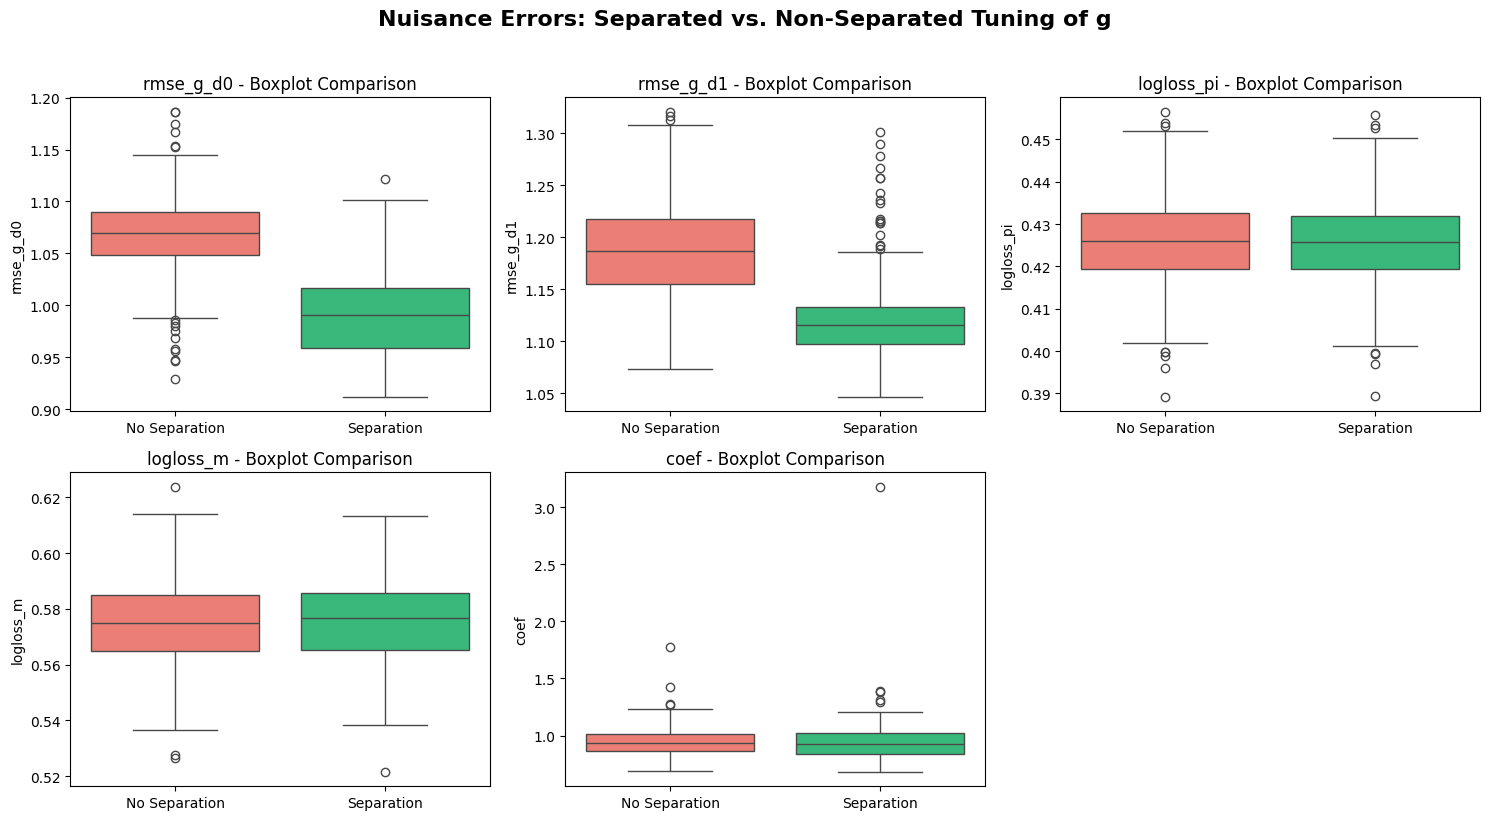

In [ ]:
color_after = "#24CD7C"  # SlateBlue for Selection-Aware Tuning
color_before = '#FF6F61'   # Coral Red for Default Tuning

metrics = ["rmse_g_d0", "rmse_g_d1", "logloss_pi", "logloss_m", "coef"]
plt.figure(figsize=(15, 8))
plt.suptitle("Nuisance Errors: Separated vs. Non-Separated Tuning of g", fontsize=16, fontweight='bold', y=1.02)


for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)  
    sns.boxplot(data=pd.DataFrame({
        "No Separation": df_joint[metric],
        "Separation": df_separate[metric]
    }), 
    palette=[color_before, color_after])
    plt.title(f"{metric} - Boxplot Comparison")
    plt.ylabel(metric)

plt.tight_layout()
plt.show()


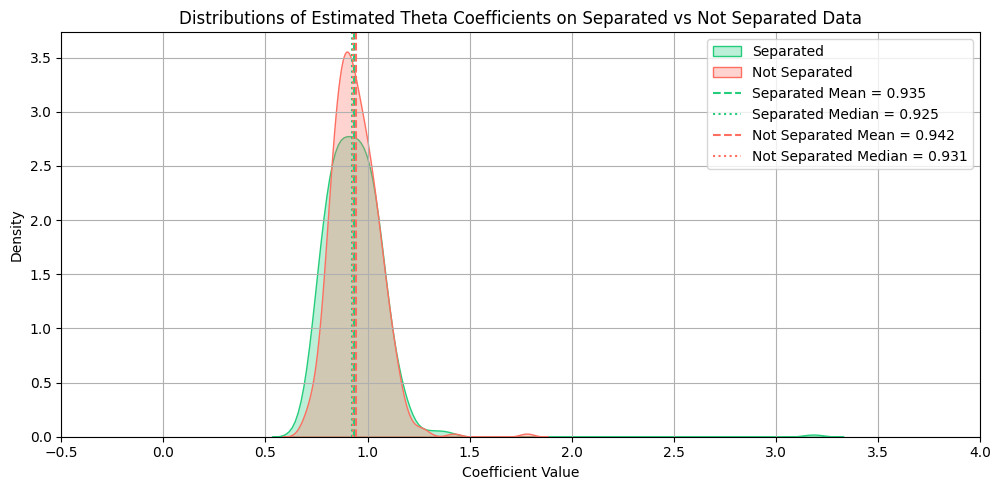

In [11]:
plt.figure(figsize=(10, 5))

sns.kdeplot(df_separate['coef'], label='Separated', color=color_after, fill=True, alpha=0.3)
sns.kdeplot(df_joint['coef'], label='Not Separated', color=color_before, fill=True, alpha=0.3)

mean_tuned = df_separate['coef'].mean()
median_tuned = df_separate['coef'].median()
mean_no_tune = df_joint['coef'].mean()
median_no_tune = df_joint['coef'].median()

plt.axvline(mean_tuned, color=color_after, linestyle='--', label=f'Separated Mean = {mean_tuned:.3f}')
plt.axvline(median_tuned, color=color_after, linestyle=':', label=f'Separated Median = {median_tuned:.3f}')
plt.axvline(mean_no_tune, color=color_before, linestyle='--', label=f'Not Separated Mean = {mean_no_tune:.3f}')
plt.axvline(median_no_tune, color=color_before, linestyle=':', label=f'Not Separated Median = {median_no_tune:.3f}')

plt.title('Distributions of Estimated Theta Coefficients on Separated vs Not Separated Data')
plt.xlabel('Coefficient Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(-0.5, 4)
plt.show()
